1)Business Understanding

I will answer the following three questions:

1)In which neighbourhood are the most listings?

2)What is the average availability per neighbourhood?

3)Which variables influence the price per listing?



To start our project it is necessary to import the following libraries: 

In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sklearn as sk





2)Data Understanding

Gather Data: To start the project it is important to import the listings.csv file.

In [23]:
df_listings = pd.read_csv('listings.csv')

Assess the data: following steps were conducted to get a better understanding of the listing dataframe (in particular the extent to which data is missing in each column)

In [24]:
#shows number of non-null values in each column and respective datatype
df_listings.info()


# shows columns with no missing values
print(df_listings.columns[np.sum(df_listings.isnull())==0])




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

c:\Users\q623737\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


It can be seen that there are some columns with no missing values, while there are other with a high number of missing values. 

3) Evaluate the Business Questions


Question 1) In the following part the neighborhoods with the highest number of listings were analysed

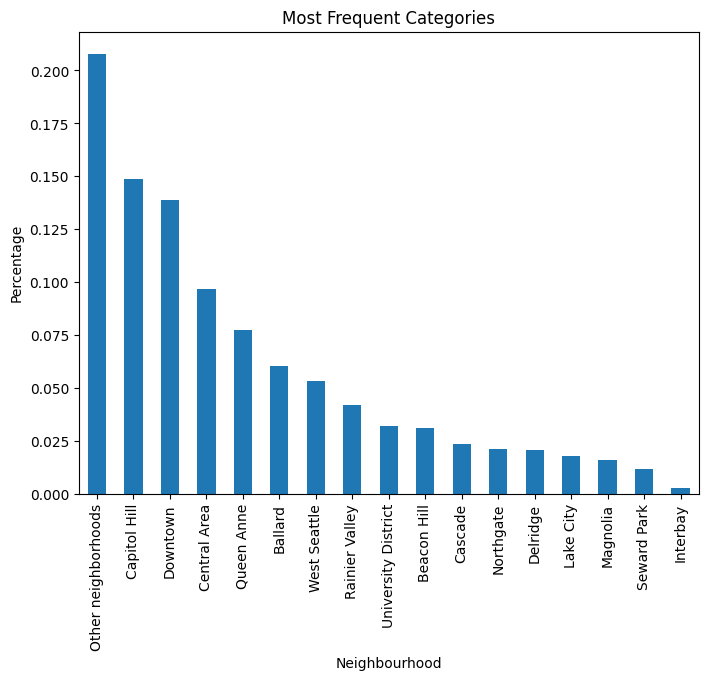

In [25]:

def analyze_visualize_categorical_feature(df, categorical_variable, title="Most Frequent Categories", xlabel="Category", ylabel="Percentage"):
    """
    Analyze the distribution of a categorical feature and visualize the results.
    
    Parameters:
    df: The DataFrame containing the data.
    categorical_variable (str): The name of the categorical feature to analyze.
    title (str, optional): The title of the plot. Defaults to "Most Frequent Categories".
    xlabel (str, optional): The label for the x-axis. Default is "Category".
    ylabel (str, optional): The label for the y-axis. Default is "Percentage".
    """
    # Analysis
    category_counts = df[categorical_variable].value_counts()
    category_percentages = (category_counts / df.shape[0])
    
    # Visualization
    fig, ax = plt.subplots(figsize=(8, 6))
    category_percentages.plot(kind="bar", ax=ax)
    xlabel="Neighbourhood"

    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

analyze_visualize_categorical_feature(df_listings, "neighbourhood_group_cleansed")


The graph shows the share of listings in each neighbourhood compared to the total number of listings. Capital Hill, Downtown and the Central Area are the Areas with the highest numer of listings. 

Question 2) Looking at the average availability per neigboorhood

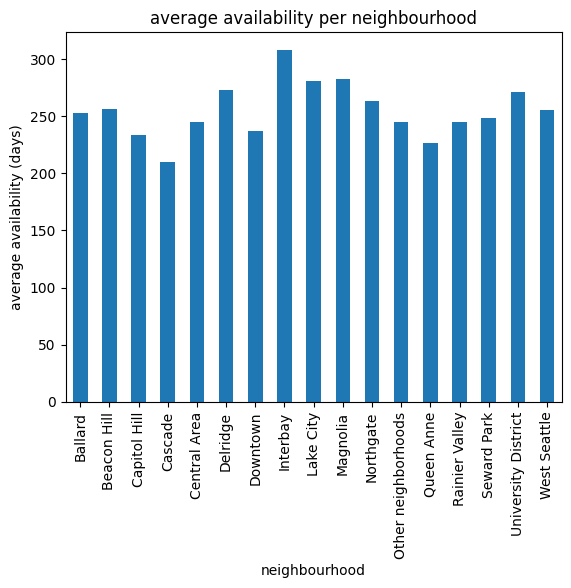

In [26]:
#Analysis:
avg_availability_by_neighborhood = df_listings.groupby('neighbourhood_group_cleansed')['availability_365'].mean()


# Visualisation: Creation of bar chart
avg_availability_by_neighborhood.plot(kind='bar')

plt.title('average availability per neighbourhood')
plt.xlabel('neighbourhood')
plt.ylabel('average availability (days)')

plt.show()


The bar chart shows the average availability in days (out of 365 days) per neighbourhood. Overall there is an availability of more than 200 days in each neighbourhood. 

Question 3) looking for the correlation between the different variables with a heatmap, focussing on the possibility to predict the price based on selected variables



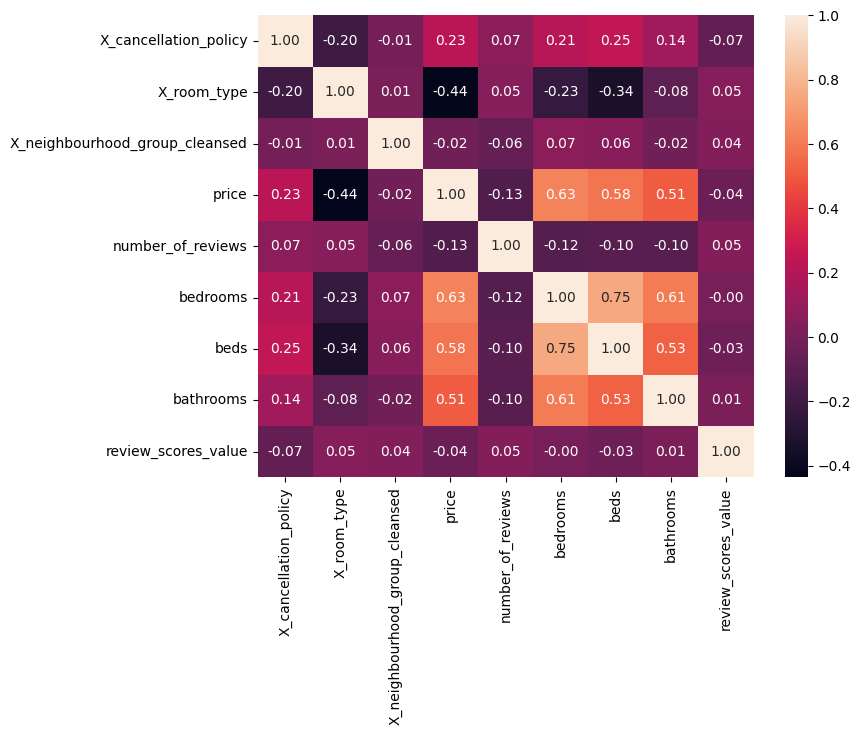

In [27]:
#Analysis:
# Data Preperation: Encoding categorical variables via the Label Encoder method, which assigns a numerical representation to each unique category value. Each category is assigned an integer from 0 to n-1, where n is the number of unique categories.
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_listings["X_neighbourhood_group_cleansed"] = encoder.fit_transform(df_listings["neighbourhood_group_cleansed"]).astype(str)
df_listings["X_cancellation_policy"] = encoder.fit_transform(df_listings["cancellation_policy"]).astype(str)
df_listings["X_room_type"] = encoder.fit_transform(df_listings["room_type"]).astype(str)



# Data Preperation:change datatype as a float data type is necessary for the heatmap we want to create later on
df_listings["X_cancellation_policy"] = df_listings["X_cancellation_policy"].astype(float)
df_listings["X_room_type"] = df_listings["X_room_type"].astype(float)
df_listings["number_of_reviews"] = df_listings["number_of_reviews"].astype(float)
df_listings["price"] = df_listings["price"].str.replace("$", "").str.replace(",", "").astype(float)


# Data Preperation: Creation of a data frame containing only the relevant variables
heatmap_data = df_listings[['X_cancellation_policy', 'X_room_type', 'X_neighbourhood_group_cleansed', 'price', 'number_of_reviews', 'bedrooms', 'beds', 'bathrooms', 'review_scores_value']]
#Data Preparation: Dealing with missing values: In order to not influence the correlation in a wrong way by imputing missing values for example with a mean, I decied that missing values are dropped. 
heatmap_data = heatmap_data.dropna()
#Creation of heatmap with selected variables

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.corr(), annot=True, fmt=".2f");

The heatmap shows the correlation between the different variables. (Attention: As we encoded categorcial variables there is no direct interpretation possible.)

Checking whether the found correlation can be used to explain the price variable by a linear regression:

In [28]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Data preperation: Creation of a dataframe with relevant variables
regression_data = df_listings[['X_cancellation_policy', 'X_room_type', 'bedrooms', 'beds', 'bathrooms','price']]
#Data preperation: Dealing with missing values: as before missing values are dropped to not influence the results. 
regression_data = regression_data.dropna()

#Analysis: linear Regression
X=regression_data[['X_cancellation_policy', 'X_room_type', 'bedrooms', 'beds', 'bathrooms']]
y=regression_data['price']

x_train , x_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

lm_model =LinearRegression(fit_intercept=True)
lm_model.fit(x_train, y_train)


# check the model fit

from sklearn.metrics import r2_score, mean_squared_error

y_pred = lm_model.predict(x_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R-Quadrat (R²): {r2:.2f}")
print(f"Mittlerer quadratischer Fehler (MSE): {mse:.2f}")
print(f"Wurzel des mittleren quadratischen Fehlers (RMSE): {rmse:.2f}")








R-Quadrat (R²): 0.48
Mittlerer quadratischer Fehler (MSE): 4183.37
Wurzel des mittleren quadratischen Fehlers (RMSE): 64.68


The model fit is not good, showing that the model is not sufficient to predict prices. 